In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if True:
    from PIL import Image    
    im = Image.open("./test_x.bmp")
    #im = Image.open("./reference_new2.bmp")
    img = np.array(im)
    print( img.shape) # Ydim, Xdim
else:
    values=np.fromfile('build/spots.bin', dtype='uint8')
    img=values.reshape([int(values.shape[0]**0.5)]*2)

(1000, 1000)


In [4]:
img.tofile('build/spots_matlab.bin','') # No sep to force binary

In [5]:
8192*8192* 4

268435456

In [6]:
1024*16

16384

In [7]:
16384 * 16384

268435456

In [8]:
#cx-boxes_x

In [9]:
#mg[cx-perside//2,]

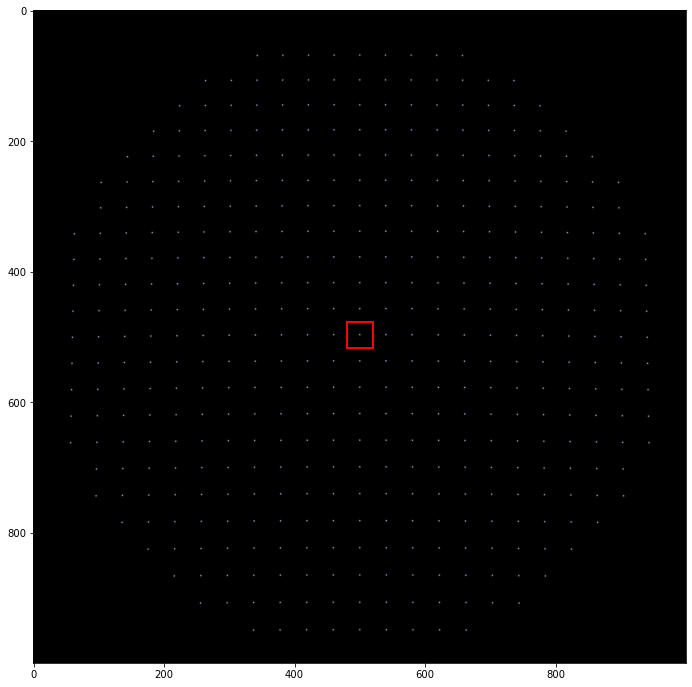

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='bone')
#plt.imsave('spots.png', img)

#cx,cy=[1038,1038]
cx,cy=[500,497]
perside=40

def box1(cx,cy):
    plt.plot( [cx-perside//2,cx+perside//2], [cy-perside//2]*2,'r-', lw=2)
    plt.plot( [cx-perside//2,cx+perside//2], [cy+perside//2]*2,'r-', lw=2)
    plt.plot( [cx-perside//2]*2, [cy-perside//2,cy+perside//2], 'r-', lw=2)
    plt.plot( [cx+perside//2]*2, [cy-perside//2,cy+perside//2], 'r-', lw=2)

box1(cx,cy)

In [11]:
437 * 4 * 2

3496

In [12]:
img.shape

(1000, 1000)

437


(16.0, 984.0, 13.0, 981.0)

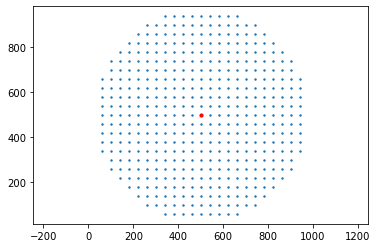

In [13]:
# Generate initial searchboxes.
# Inspired by the MATLAB code, but converted to matrix ops instead of loops
#pupil_radius_pixel = 2000 #np.max(img.shape)//2
#box_size_pixel = 100/6.4
pupil_radius_pixel = np.max(img.shape)//2
box_size_pixel = 40

# How many "boxwidths" (radius) in the pupil
ri_ratio = pupil_radius_pixel / box_size_pixel

# The max number of boxes possible + or -
max_boxes = np.ceil( pupil_radius_pixel/ box_size_pixel )

# All possible bilinear box
boxes_x = np.arange(-max_boxes,max_boxes+1) # +1 to include +max_boxes number
boxes_y = np.arange(-max_boxes,max_boxes+1)

# Determine outer edge of each box using corners away from the center:
# 0.5*sign: positive adds 0.5, negative substracts 0.5
#
# Filter valid to only those where the radius is within ri_ratio
XX,YY = np.meshgrid(boxes_x, boxes_y )
RR = np.sqrt( (XX+0.5*np.sign(XX))**2 + (YY+0.5*np.sign(YY))**2 )
valid_boxes = np.where(RR<ri_ratio)
max_dist_boxwidths = np.max(RR[RR<ri_ratio])

# Normalize to range -1 .. 1 (vs. pupil size)
valid_x_norm=XX[valid_boxes]/ri_ratio
valid_y_norm=YY[valid_boxes]/ri_ratio

num_boxes=valid_x_norm.shape[0]
print( num_boxes )
box_zero = np.where(valid_x_norm**2+valid_y_norm**2==0)[0] # Locate the central box

valid_x = valid_x_norm * 500 + cx
valid_y = valid_y_norm * 500 + cy
plt.scatter( valid_x, valid_y, s=2)
plt.scatter( valid_x[box_zero], valid_y[box_zero], s=10, color='red')
plt.axis('equal')

In [64]:
lefts = valid_x_norm-0.5/ri_ratio
rights = valid_x_norm+0.5/ri_ratio
ups = -( valid_y_norm+0.5/ri_ratio )
downs = -( valid_y_norm-0.5/ri_ratio )

In [504]:
ri_ratio

12.5

In [143]:
import zernike_integrals
from numpy.linalg import svd,lstsq

In [82]:
lenslet_dx,lenslet_dy=zernike_integrals.zernike_integral_average_from_corners(
    lefts,rights,ups,downs,20,20)
lenslet_dx /= 6400/1000/2 # pupil
lenslet_dy /= 6400/1000/2 # puil

In [83]:
start_zc=1 # Zero-based, skip first term
num_zcs=68

lenslet_dx = lenslet_dx[start_zc:num_zcs,:].T
lenslet_dy = lenslet_dy[start_zc:num_zcs,:].T

In [175]:
lenslet_dx

array([[-0.        ,  0.625     ,  1.90525589, ...,  8.11155096,
        -4.57779448, -9.2595001 ],
       [-0.        ,  0.625     ,  1.90525589, ...,  4.7080723 ,
        -9.68618577, -8.07625732],
       [-0.        ,  0.625     ,  1.90525589, ...,  0.25748942,
        -8.37761825, -2.38498841],
       ...,
       [-0.        ,  0.625     , -1.90525589, ..., -0.25748942,
         8.37761825,  2.38498841],
       [-0.        ,  0.625     , -1.90525589, ..., -4.7080723 ,
         9.68618577,  8.07625732],
       [-0.        ,  0.625     , -1.90525589, ..., -8.11155096,
         4.57779448,  9.2595001 ]])

In [373]:
zpoly = np.hstack( (lenslet_dx.T, lenslet_dy.T ) ).T
[uu,ss,vv] = svd(zpoly,False)
ss_full = eye(ss.shape[0])*ss

In [528]:
import scipy.io
mat_solution=scipy.io.loadmat('../miniwave/matlab_centroid_ui/Zernike fit to spot centroids/svd_vars.mat')

In [347]:
np.shape(zpoly)

(874, 67)

In [349]:
np.max( (zpoly-mat_solution['zpoly'] ) )

2.1502410962881413e-11

In [356]:
np.max( np.matmul(uu*ss,vv) )

13.546229697245174

In [202]:
uu.shape,ss.shape,ss_full.shape,vv.shape

((874, 67), (67,), (67, 67), (67, 67))

In [203]:
wow=np.dot( vv / ss_full, uu.T )

/tmp/ipykernel_513188/1383175677.py:1: RuntimeWarning: divide by zero encountered in true_divide
  wow=np.dot( vv / ss_full, uu.T )
/tmp/ipykernel_513188/1383175677.py:1: RuntimeWarning: invalid value encountered in true_divide
  wow=np.dot( vv / ss_full, uu.T )


In [387]:
leftside = numpy.linalg.lstsq(ss_full, vv, rcond=0)[0].T # Python equiv to MATLAB's vv/ss (solving system of eqns)
zterms = np.matmul( leftside, uu.T)
coeff=np.matmul(zterms,mat_solution['slope'])

#zernikeCVS=np.zeros(num_zcs)
#zernikeCVS[start_zc:num_zcs] = coeff

ValueError: could not broadcast input array from shape (67,1) into shape (67,)

In [519]:
np.concatenate( ([1,2],[3,4]) )

array([1, 2, 3, 4])

In [516]:
size( mat_solution['slope'] )

874

In [514]:
x=np.array([1,2,3]); y=np.array([4,5,6])
wow=np.vstack((x,y)).T
wow.shape


(3, 2)

In [497]:
# Copied from MATLAB code
CVS_to_OSA_map = np.array([3,2, 5,4,6, 9,7,8,10, 15,13,11,12,14,
                           21,19,17,16,18,20,
                           27,25,23,22,24,26,28, 35,33,31,29,30,32,34,36,
                           45,43,41,39,37,38,40,42,44,
                           55,53,51,49,47,46,48,50,52,54,
                           65,63,61,59,57,56,58,60,62,64,66,67,68,69,70])

zernike_OSA=coeff[CVS_to_OSA_map[start_zc-1:num_zcs-1]-start_zc-1 ]

In [486]:
#list(zip(np.arange(len(CVS_to_OSA_map)), CVS_to_OSA_map) )

In [499]:
np.max( zernike_OSA - mat_solution['zernikeOSA'][0:67] )

9.547918011776346e-15

In [500]:
np.max(coeff - mat_solution['coeff'] )

9.547918011776346e-15

In [538]:
np.max(zterms - mat_solution['zterms'] )

2.8367878792540102e-15

In [120]:
vv/(eye(ss.shape[0])*ss)*uu.T

/tmp/ipykernel_513188/1941473125.py:1: RuntimeWarning: divide by zero encountered in true_divide
  vv/(eye(ss.shape[0])*ss)*uu.T
/tmp/ipykernel_513188/1941473125.py:1: RuntimeWarning: invalid value encountered in true_divide
  vv/(eye(ss.shape[0])*ss)*uu.T


ValueError: operands could not be broadcast together with shapes (67,67) (67,874) 

In [536]:
zt1=np.load('zterms.npy')
slope=np.load('slope.npy')

In [532]:
np.max( zt1-zterms )

0.0

In [542]:
np.max(mat_solution['slope']-slope)

13.01006528155903

In [549]:
np.shape(mat_solution['slope'][0])

(1,)

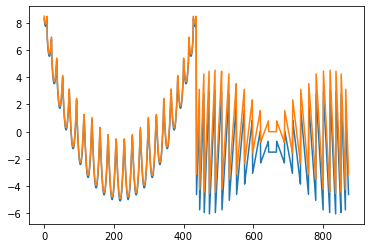

In [557]:
plot(slope-1.5);
plot(mat_solution['slope'] )

In [533]:
mat_solution['slope']-slope

array([[ 1.82675181e+01,  1.80198089e+01,  1.78463248e+01, ...,
         1.00499269e+01,  1.07896803e+01,  1.15879868e+01],
       [ 1.80143341e+01,  1.77666249e+01,  1.75931408e+01, ...,
         9.79674287e+00,  1.05364963e+01,  1.13348028e+01],
       [ 1.78472304e+01,  1.75995212e+01,  1.74260371e+01, ...,
         9.62963914e+00,  1.03693926e+01,  1.11676990e+01],
       ...,
       [ 8.23249136e+00,  7.98478214e+00,  7.81129802e+00, ...,
         1.49001118e-02,  7.54653525e-01,  1.55296000e+00],
       [ 7.47922072e+00,  7.23151150e+00,  7.05802738e+00, ...,
        -7.38370524e-01,  1.38288877e-03,  7.99689362e-01],
       [ 6.67917590e+00,  6.43146668e+00,  6.25798256e+00, ...,
        -1.53841534e+00, -7.98661931e-01, -3.55457084e-04]])

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='bone')
box1(valid_x[box_zero], valid_y[box_zero])
box1(valid_x[0], valid_y[0])
box1(valid_x[8], valid_y[8])
box1(valid_x[-1], valid_y[-1])

In [ ]:
plt.imshow(img[60:70,340:350])

In [ ]:
layout=extract_memory.get_header_format('memory_layout.h')    

In [ ]:
defs,size

In [ ]:
# https://stackoverflow.com/questions/63553692/how-to-use-memory-mapped-file-in-python-linux


In [ ]:
import extract_memory
size,fields,defs=extract_memory.get_header_format('layout_boxes.h')

In [ ]:
import extract_memory
size,fields,defs=extract_memory.get_header_format('layout_boxes.h')

import struct

import os
import mmap
NUM_BOXES=defs['MAX_BOXES']
fd = os.open('/dev/shm/NW_BUFFER2',os.O_RDWR)
shmem_boxes=mmap.mmap(fd,size)


class ByteStream(bytearray):
    def append(self, v, fmt='>B'):
        self.extend(struct.pack(fmt, v))

buf = ByteStream()
for item in valid_x:
    buf.append(item, 'f')
shmem_boxes.seek(fields['reference_x']['bytenum_current'])
shmem_boxes.write(buf)
shmem_boxes.flush()
               
buf = ByteStream()
for item in valid_y:
    buf.append(item, 'f')
shmem_boxes.seek(fields['reference_y']['bytenum_current'])
shmem_boxes.write(buf)
shmem_boxes.flush()

# Write header last, so the engine knows when we are ready
buf = ByteStream()
buf.append(1)
buf.append(2)
buf.append(num_boxes, 'H')
buf.append(box_size_pixel, 'd')
buf.append(pupil_radius_pixel, 'd')
shmem_boxes.seek(0)
shmem_boxes.write(buf)
shmem_boxes.flush()

os.close(fd)

In [ ]:
shmem_boxes.seek(fields['centroid_x']['bytenum_current'])
buf=shmem_boxes.read(num_boxes*4)
centroids_x=struct.unpack_from(''.join((['f']*num_boxes)), buf)

shmem_boxes.seek(fields['centroid_y']['bytenum_current'])
buf=shmem_boxes.read(num_boxes*4)
centroids_y=struct.unpack_from(''.join((['f']*num_boxes)), buf)


In [ ]:
plt.plot( centroids_x, centroids_y, '.')
plt.axis('equal')

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(img, cmap='bone')
plt.plot( centroids_x, centroids_y, 'r.', ms=2)

plt.plot( ref_x, ref_y, 'b.', ms=2)

In [ ]:
#buf


In [ ]:
0xb5 * 256 + 0x1

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( img.mean(1) )

In [ ]:
1038,1038